In this notebook the movie tilte and plot get embedded. With `SentenceTransformer` for each movie a 384-demensional embeddings representing the tilte and plot is calculated. In an further step these high dimensional vectores get reduced to low demensional vectors using UMAP and t-SNE. 

The reduction of dimensionalities result in faster training times and also more stable training.

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.manifold import TSNE

from umap import UMAP

import torch
from torch.nn import Linear, MSELoss
import torch.nn.functional as F

from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.transforms import RandomLinkSplit, ToUndirected, AddSelfLoops, NormalizeFeatures

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Load data

In [3]:
user_df = pd.read_csv('data/movieLens100k_users.csv')

print(user_df.shape)
user_df.head()

(671, 1)


,userId
0,0
1,1
2,2
3,3
4,4


In [4]:
movie_df = pd.read_csv('data/movieLens100k_movies.csv')

print(movie_df.shape)
movie_df.head()

(9125, 28)


,movieId,title,plot,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Sci-Fi,Thriller,War,Western,imdbRating,imdbVotes,runtime,year,num_popular_actors,num_popular_directors
0,0,Toy Story,A cowboy doll is profoundly threatened and jea...,0,1,1,1,1,0,0,...,0,0,0,0,1.528928,5.144229,-0.876122,0.158905,2.943417,4.502288
1,1,Jumanji,When two kids find and play a magical board ga...,0,1,0,1,0,0,0,...,0,0,0,0,0.174897,1.394602,-0.058951,0.158905,1.228413,-0.218854
2,2,Grumpier Old Men,John and Max resolve to save their beloved bai...,0,0,0,0,1,0,0,...,0,0,0,0,-0.115253,-0.318207,-0.165539,0.158905,-0.486591,-0.218854
3,3,Waiting to Exhale,"Based on Terry McMillan's novel, this film fol...",0,0,0,0,1,0,0,...,0,0,0,0,-1.082418,-0.426889,0.651632,0.158905,-0.486591,-0.218854
4,4,Father of the Bride Part II,"In this sequel, George Banks deals not only wi...",0,0,0,0,1,0,0,...,0,0,0,0,-0.792268,-0.248423,0.012107,0.158905,1.228413,-0.218854


In [5]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                9125 non-null   int64  
 1   title                  9125 non-null   object 
 2   plot                   9125 non-null   object 
 3   Action                 9125 non-null   int64  
 4   Adventure              9125 non-null   int64  
 5   Animation              9125 non-null   int64  
 6   Children               9125 non-null   int64  
 7   Comedy                 9125 non-null   int64  
 8   Crime                  9125 non-null   int64  
 9   Documentary            9125 non-null   int64  
 10  Drama                  9125 non-null   int64  
 11  Fantasy                9125 non-null   int64  
 12  Film-Noir              9125 non-null   int64  
 13  Horror                 9125 non-null   int64  
 14  IMAX                   9125 non-null   int64  
 15  Musi

In [6]:
rating_df = pd.read_csv('data/movieLens100k_ratings.csv')

print(rating_df.shape)
rating_df.head()

(100004, 3)


,userId,movieId,rating
0,0,1815,2.0
1,0,1962,2.5
2,0,2380,1.0
3,0,2925,3.0
4,0,1515,4.0


### Title and plot embedding

We have to embed the title and the movie plot. I use the library sentence transformers. SentenceTransformers is a Python framework for state-of-the-art sentence, text and image embeddings. 

In [7]:
movie_df[['movieId', 'title', 'plot']]

,movieId,title,plot
0,0,Toy Story,A cowboy doll is profoundly threatened and jea...
1,1,Jumanji,When two kids find and play a magical board ga...
2,2,Grumpier Old Men,John and Max resolve to save their beloved bai...
3,3,Waiting to Exhale,"Based on Terry McMillan's novel, this film fol..."
4,4,Father of the Bride Part II,"In this sequel, George Banks deals not only wi..."
...,...,...,...
9120,9120,Mohenjo Daro,A period adventure and love story set during t...
9121,9121,Shin Godzilla,Japan is plunged into chaos upon the appearanc...
9122,9122,The Beatles: Eight Days a Week - The Touring Y...,A compilation of found footage featuring music...
9123,9123,The Gay Desperado,"Chivo, a singer who works in a movie theater p..."


In [8]:
movie_df.loc[111, 'plot']

'Two melancholy Hong Kong policemen fall in love: one with a mysterious female underworld figure, the other with a beautiful and ethereal server at a late-night restaurant he frequents.'

In [9]:
sentences = movie_df['plot'].to_list()
print('# of sentences:', len(sentences))
assert len(sentences) == len(movie_df), 'Shape missmatch. Check if there are any null-values in the plot.'

# of sentences: 9125


In [10]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
plot_embeddings = model.encode(sentences)
plot_embeddings.shape, plot_embeddings[0]

((9125, 384),
 array([-2.83514298e-02, -1.84655376e-02,  4.55664992e-02, -6.73980918e-03,
         1.58164604e-03, -2.34077089e-02,  1.52290221e-02,  2.85078455e-02,
        -4.91095707e-02,  3.20482031e-02,  2.33482849e-02, -1.17351336e-03,
         8.34142640e-02, -3.13076228e-02,  1.41747463e-02,  2.72149127e-02,
         8.89891088e-02,  3.35503109e-02, -2.32784692e-02, -2.24349964e-02,
         7.29824416e-03, -1.45680746e-02, -4.11115587e-02,  4.98188585e-02,
        -6.84763268e-02, -3.73839960e-02, -7.91816972e-03,  5.27191423e-02,
        -2.73374096e-02,  9.30573419e-03, -2.34319754e-02, -3.87955345e-02,
         8.19623098e-03, -4.21063742e-03, -4.58212948e-04,  1.00464188e-01,
        -2.23493204e-02, -8.55326355e-02,  3.25274803e-02, -5.50645739e-02,
        -5.26372604e-02,  3.42741306e-03, -1.61870581e-03,  2.46253964e-02,
        -6.68734908e-02, -5.77454269e-02, -1.73136394e-03, -2.82837097e-02,
         6.21164292e-02, -4.54500206e-02, -4.72014882e-02, -1.29756713e-02

In [11]:
movie_df.drop(columns=['title', 'plot'], axis=1, inplace=True)
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                9125 non-null   int64  
 1   Action                 9125 non-null   int64  
 2   Adventure              9125 non-null   int64  
 3   Animation              9125 non-null   int64  
 4   Children               9125 non-null   int64  
 5   Comedy                 9125 non-null   int64  
 6   Crime                  9125 non-null   int64  
 7   Documentary            9125 non-null   int64  
 8   Drama                  9125 non-null   int64  
 9   Fantasy                9125 non-null   int64  
 10  Film-Noir              9125 non-null   int64  
 11  Horror                 9125 non-null   int64  
 12  IMAX                   9125 non-null   int64  
 13  Musical                9125 non-null   int64  
 14  Mystery                9125 non-null   int64  
 15  Roma

In [12]:
assert not movie_df.isnull().values.any(), 'Null values in dataset!'

In [13]:
print('Movie DF shape:', movie_df.shape, '\nEmbeddings shape:', plot_embeddings.shape)

Movie DF shape: (9125, 26) 
Embeddings shape: (9125, 384)


### Reduce Plot Embedding Dimensionality

The pretrained hugging-face NLP model returns Emdeddings of 384 dimensions. Compared to 24 dimensional movie embedding (genres, runtime, year, etc.), it seems that the plot embedding is overweighted. Here we try different dimensionalty reduction methods such as t-SNE and U-Map. 

In [14]:
print('Compute t-SNE manifold reduction (2D)....')
tsne_2d = TSNE(n_components=2, perplexity=19, init='random', learning_rate='auto')
plot_embed_tsne_reduced_2d = tsne_2d.fit_transform(plot_embeddings)

print('Compute u-Map manifold reduction (2D)....')
umap_2d = UMAP(n_neighbors=15, n_components=2, init='random', random_state=11)
plot_embed_umap_reduced_2d = umap_2d.fit_transform(plot_embeddings)

print('Compute u-Map manifold reduction (4D)....')
umap_4d = UMAP(n_neighbors=15, n_components=4, init='random', random_state=11)
plot_embed_umap_reduced_4d = umap_4d.fit_transform(plot_embeddings)

print('Compute u-Map manifold reduction (8D)....')
umap_8d = UMAP(n_neighbors=15, n_components=8, init='random', random_state=11)
plot_embed_umap_reduced_8d = umap_8d.fit_transform(plot_embeddings)

print('t-SNE (2D) shape:', plot_embed_tsne_reduced_2d.shape)
print('u-Map (2D) shape:', plot_embed_umap_reduced_2d.shape)
print('t-SNE (4D) shape:', plot_embed_umap_reduced_4d.shape)
print('t-SNE (8D) shape:', plot_embed_umap_reduced_8d.shape)

Compute t-SNE manifold reduction (2D)....
Compute u-Map manifold reduction (2D)....
Compute u-Map manifold reduction (4D)....
Compute u-Map manifold reduction (8D)....
t-SNE (2D) shape: (9125, 2)
u-Map (2D) shape: (9125, 2)
t-SNE (4D) shape: (9125, 4)
t-SNE (8D) shape: (9125, 8)


In [15]:
do_save = False

if do_save:
    np.save('data/np_plot_embeddings.npy', plot_embeddings)
    np.save('data/np_plot_embeddings_tsne_2d.npy', plot_embed_tsne_reduced_2d)
    np.save('data/np_plot_embeddings_umap_2d.npy', plot_embed_umap_reduced_2d)
    np.save('data/np_plot_embeddings_umap_4d.npy', plot_embed_umap_reduced_4d)
    np.save('data/np_plot_embeddings_umap_8d.npy', plot_embed_umap_reduced_8d)
    # np.save('/data/np_movie_array.npy', movie_df.values)

    print('Plot Embeddings saved!')

### Create Pytorch Geometric (heterogenious) Dataset

In [16]:
def create_hetero_dataset(plot_embedding:np.array) -> dict:
    user_embeddings = np.load('./data/np_user_embeddings_20221125.npy')
    x_user = torch.Tensor(user_embeddings)

    x_movie = movie_df.drop(columns=['movieId'], axis=1)
    x_movie = x_movie.values
    
    if plot_embedding is not None:
        x_movie = np.concatenate((x_movie, plot_embedding), axis=1)
    x_movie = torch.Tensor(x_movie)
    x_movie.size()

    edge_index = torch.Tensor(rating_df[['userId', 'movieId']].values).swapaxes(1,0).to(torch.long)
    edge_index.size(), edge_index

    edge_label = torch.Tensor(rating_df['rating'].values)
    edge_label.size(), edge_label

    data = HeteroData()
    data['user'].x = x_user
    data['movie'].x = x_movie

    data[('user', 'rates', 'movie')].edge_index = edge_index
    data[('user', 'rates', 'movie')].edge_label = edge_label

    data = ToUndirected()(data)
    del data[('movie', 'rev_rates', 'user')].edge_label
    
    data = data.to(device)
    print(data)

    return data

In [17]:
data = create_hetero_dataset(plot_embedding=None)

HeteroData(
  user={ x=[671, 8] },
  movie={ x=[9125, 25] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100004] }
)


### GNN Model

In [18]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        # self.lin2 = Linear(hidden_channels, hidden_channels)    # new
        self.lin_out = Linear(hidden_channels, 1)
        
    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        # concat user and movie embeddings
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
        # concatenated embeddings passed to linear layer
        z = self.lin1(z).relu()
        # z = self.lin2(z).relu()    #new
        z = self.lin_out(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        # z_dict contains dictionary of movie and user embeddings returned from GraphSage
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [19]:
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    target = data['user', 'movie'].edge_label
    # loss = weighted_mse_loss(pred, target, weight)
    loss = F.mse_loss(pred, target).sqrt()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(model, data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [20]:
comp_val_losses = []
for embed in [None, plot_embeddings, plot_embed_tsne_reduced_2d, plot_embed_umap_reduced_2d, 
             plot_embed_umap_reduced_4d, plot_embed_umap_reduced_8d]:
    if embed is None:
        print('Without plot embeddings.')
    else:
        print(embed.shape)
    
    data = create_hetero_dataset(embed)

    # Train/Test Splitting
    train_data, val_data, test_data = RandomLinkSplit(
        num_val=0.1,
        num_test=0.1,
        neg_sampling_ratio=0.0,
        edge_types=[('user', 'rates', 'movie')],
        rev_edge_types=[('movie', 'rev_rates', 'user')],
    )(data)

    # Model
    model = Model(hidden_channels=64).to(device)

    # Lazy init
    with torch.no_grad():
        model.encoder(train_data.x_dict, train_data.edge_index_dict)

    optimizer = torch.optim.Adam(model.parameters())

    # Training
    EPOCHS = 250
    train_losses, val_losses, test_losses = [], [], []
    for epoch in range(1, EPOCHS+1):
        train_loss = train(model=model, data=train_data, optimizer=optimizer)
        # train_rmse = test(train_data)
        val_rmse = test(model=model, data=val_data)
        test_rmse = test(model=model, data=test_data)
        
        train_losses.append(train_loss), val_losses.append(val_rmse), test_losses.append(test_rmse)
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}\tTrain: {train_loss:.4f}\t'
                f'Val: {val_rmse:.4f}\tTest: {test_rmse:.4f}')

    comp_val_losses.append(val_losses)

Without plot embeddings.
HeteroData(
  user={ x=[671, 8] },
  movie={ x=[9125, 25] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100004] }
)
Epoch: 010	Train: 1.9667	Val: 1.6949	Test: 1.7181
Epoch: 020	Train: 1.2675	Val: 1.1238	Test: 1.1131
Epoch: 030	Train: 1.1182	Val: 1.0975	Test: 1.1040
Epoch: 040	Train: 1.0340	Val: 1.0296	Test: 1.0237
Epoch: 050	Train: 0.9998	Val: 1.0133	Test: 1.0096
Epoch: 060	Train: 0.9827	Val: 1.0044	Test: 1.0014
Epoch: 070	Train: 0.9693	Val: 0.9890	Test: 0.9816
Epoch: 080	Train: 0.9530	Val: 0.9772	Test: 0.9707
Epoch: 090	Train: 0.9385	Val: 0.9666	Test: 0.9594
Epoch: 100	Train: 0.9250	Val: 0.9555	Test: 0.9467
Epoch: 110	Train: 0.9131	Val: 0.9454	Test: 0.9354
Epoch: 120	Train: 0.9020	Val: 0.9359	Test: 0.9252
Epoch: 130	Train: 0.8920	Val: 0.9271	Test: 0.9159
Epoch: 140	Train: 0.8839	Val: 0.9191	Test: 0.9075
Epoch: 150	Train: 0.8782	Val: 0.9121	Test: 0.9001
Epoch: 160	Train: 0.8742	V

In [21]:
len(comp_val_losses), len(comp_val_losses[0])

(6, 250)

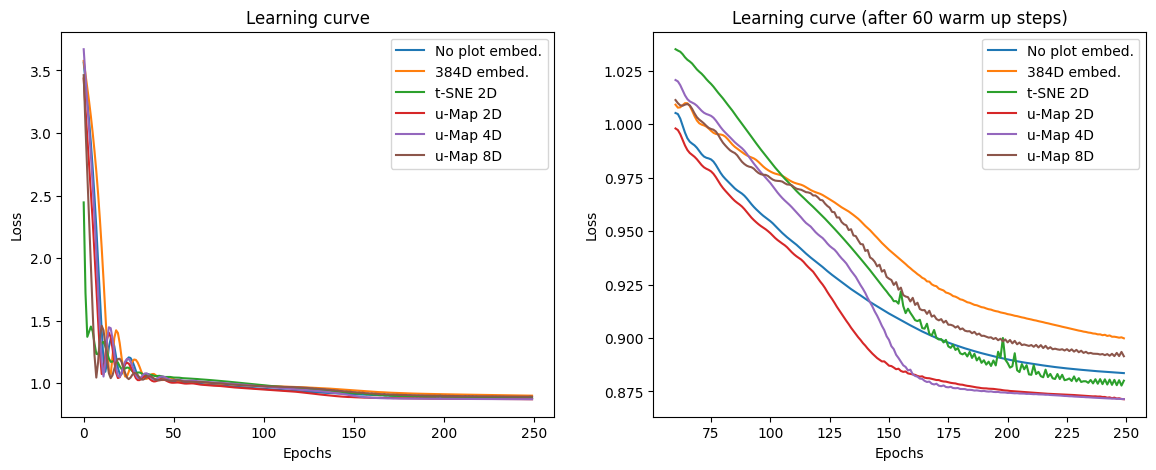

In [22]:
SKIP_WARM_UP_STEPS = 60

maps = ['No plot embed.', '384D embed.', 't-SNE 2D', 'u-Map 2D', 'u-Map 4D', 'u-Map 8D']

_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
for i, label in enumerate(maps):
    ax0.plot(comp_val_losses[i], label=label)
    ax1.plot(range(SKIP_WARM_UP_STEPS, len(comp_val_losses[0])), comp_val_losses[i][SKIP_WARM_UP_STEPS:], label=label)

ax0.set_title('Learning curve')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Loss')
ax0.legend()

ax1.set_title(f'Learning curve (after {SKIP_WARM_UP_STEPS} warm up steps)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
plt.show()